<a href="https://colab.research.google.com/github/ingUANDES/BlockchainAdoption/blob/main/code/Financial_Networks_Stability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---


## 4/11/2024

### Ejemplo 5 Jalan et alii (2024)

### Importar librerías necesarias

In [3]:
from sympy import *
init_printing()
from numpy.linalg import *
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series, DataFrame
from scipy.stats import truncnorm, wishart
from scipy.linalg import solve, solve_sylvester
from functools import partial
from scipy.linalg import toeplitz
import numpy as np

In [5]:
DEFAULT_NUM_FIRMS = 3

####################
## Gen fns
####################
def generate_firm_covariances(num_firms = DEFAULT_NUM_FIRMS,
                              num_samples = DEFAULT_NUM_FIRMS,
        risk_aversion = 1.0, entry_distribution = 'gaussian',
        noise_param = 1.0, subtract_mean = False, return_inv = False):
    cov_matrix = np.zeros(shape = (num_firms, num_firms))
    # need n iterations. at each iteration add a random rank-1 matrix.

    for i in range(num_samples):
        if entry_distribution == 'gaussian':
            A = np.random.normal(loc = 0.0, scale = noise_param, size=(num_firms, 1))
        elif entry_distribution == 'exponential':
            A = np.random.exponential(noise_param, size=(num_firms, 1))
        elif entry_distribution == 'eye':
            A = np.eye(1, num_firms, i).T
        else:
            raise Exception(f'Distribution {entry_distribution} is unknown')
        symmA = np.matmul(A, A.T)
        cov_matrix += symmA
    cov_matrix_normalized = np.copy(cov_matrix)
    if subtract_mean:
        cov_matrix_normalized = cov_matrix - cov_matrix.mean(axis=1, keepdims=True)

    # normalize by num_samples so it has a reasonable scale.
    if entry_distribution != 'eye':
        cov_matrix_normalized *= (1.0 / num_samples)

    # scale by risk aversion parameter.
    cov_matrix_normalized *= risk_aversion

    if return_inv:
        return cov_matrix_normalized, np.linalg.inv(cov_matrix_normalized)
    return cov_matrix_normalized

def generate_means(num_firms = DEFAULT_NUM_FIRMS):
    init = np.random.normal(loc = 5, scale = 1.0, size=(num_firms, num_firms))
    for i in range(num_firms):
        init[i][i] = 0.0
    return init

####################
## Solver fns
####################

def construct_prohibition_matrices(n, prohibited_tuples):
    # tuples belong to {0, 1, ..., n-1}

    # Initialize an empty list to store the matrices
    matrices = [np.eye(n) for _ in range(n)]
    rows_to_delete = {i: [] for i in range(n)}

    # Create the identity matrix of size n x n
    # identity_matrix = np.identity(n)

    # Loop through each prohibited tuple
    for prohibited_edge in prohibited_tuples:
        i, j = prohibited_edge
        rows_to_delete[i].append(j)
        rows_to_delete[j].append(i)
    matrices = [np.delete(np.eye(n), rows_to_delete[i], axis=0) for i in range(n)]
    return matrices

def construct_q_matrices(Sigma_matrices, prohibition_matrices, Gamma = None):
    out = []
    n = len(Sigma_matrices)
    if Gamma is None:
        Gamma = np.eye(n)
    for i in range(n):
        inner = 2 * Gamma[i, i] * (prohibition_matrices[i] @ Sigma_matrices[i] @ prohibition_matrices[i].T)
        outer = prohibition_matrices[i].T @ np.linalg.inv(inner) @ prohibition_matrices[i]
        out.append(outer.copy())
    return out




def opt_portfolio_mat(S_inv, M, P, Gamma = None):
    sol_mat = np.matmul(0.5 * S_inv, M - P)
    if Gamma is None:
        return sol_mat
    return np.matmul(sol_mat, np.linalg.inv(Gamma))

# todo update price sylvester for Gamma
def price_soln_sylvester(S_inv, mean_matrix):
    Q = 0.5 * S_inv
    return la.solve_sylvester(Q, Q,
        np.matmul(Q, mean_matrix) - np.matmul(mean_matrix.T, Q))

################################
################################
# Dynamics
################################
################################
def get_percent_change(current, previous):
    if current == previous:
        return 100.0
    try:
        return (abs(current - previous) / previous) * 100.0
    except ZeroDivisionError:
        return 0

def get_iden_missing_row(n, i):
    iden = np.eye(n)
    iden[i, i] = 0.0
    return iden

def price_update_naive(i, j, P_init, Q_matrices_list, mean_matrix, eta = 1.0):
    if i == j:
        return 0.0

    diff_mat = mean_matrix - P_init
    prod_i = Q_matrices_list[i] @ diff_mat
    prod_j = Q_matrices_list[j] @ diff_mat

    diff_scalar = prod_j[i, j] - prod_i[j, i]
    denom = Q_matrices_list[i][j, j] + Q_matrices_list[j][i,i]

    shift = diff_scalar / denom
    old_price = P_init[i, j]
    p_prime = shift + old_price
    new_price = eta * p_prime + (1.0 - eta) * old_price
    return new_price

# assuming shared Sigma and Gamma = I
def opt_w_with_edge_constraints(Q_matrices_list, M, P):
    n = M.shape[0]
    # prohibition_matrices = construct_prohibition_matrices(n, prohibited_edges_tuples)
    # Q_matrices_list = construct_q_matrices([Sigma_shared.copy() for _ in range(n)], prohibition_matrices)
    w_list = []
    for i in range(n):
        w_i = Q_matrices_list[i] @ (M[:, i] - P[:, i])
        w_list.append(w_i)
    W_mat = np.vstack(w_list).T
    # print('W opt is ', W_mat)
    return W_mat

def run_price_dyanmics_one_step(Q_matrices_list, mean_matrix, P_init, prohibited_edges_tuples = [], eta = 1.0):
    # prohibited_edges_tuples is a list of pairs, e.g. [(1, 3), (2, 3), (2, 5)]

    # sinv = np.linalg.inv(sigma_shared)
    # W_current = opt_portfolio_mat(sinv, mean_matrix, P_init)
    # print('q matrices are: ', Q_matrices_list)
    W_current = opt_w_with_edge_constraints(Q_matrices_list, mean_matrix, P_init)
    P_new = np.zeros(shape = P_init.shape)
    n = P_init.shape[0]

    for i in range(n):
        for j in range(i):
            # check that contract prices disagree
            if (j, i) not in prohibited_edges_tuples and (i, j) not in prohibited_edges_tuples:
                # print(f'Updating price at {(j,i)}')
                # print(W_current)
                # print(W_current.shape)
                pct_w_diff = get_percent_change(W_current[i, j], W_current[j, i])
                if np.abs(pct_w_diff) > 1e-1:
                    updated_price_ij = price_update_naive(i, j, P_init, Q_matrices_list, mean_matrix, eta = eta)
                    P_new[i, j] = updated_price_ij
                    P_new[j, i] = -1 * updated_price_ij
                else:
                    P_new[i, j] = P_init[i, j]
                    P_new[j, i] = P_init[j, i]
    # W_new = opt_portfolio_mat(sinv, mean_matrix, P_new)
    W_new = opt_w_with_edge_constraints(Q_matrices_list, mean_matrix, P_new)
    return W_new, P_new

def run_price_dynamics(sigma_shared, mean_matrix, prohibited_edges_tuples = [],
                       num_iterations = 50,
                       eta = 0.0, Gamma=None):
    n = mean_matrix.shape[0]
    prohibition_matrices = construct_prohibition_matrices(n, prohibited_edges_tuples)
    Q_matrices_list = construct_q_matrices([sigma_shared.copy() for _ in range(n)], prohibition_matrices,
                                          Gamma=Gamma)
    print(f'Q matrices: {Q_matrices_list}')
    P_current = np.zeros_like(sigma_shared)
    # sinv = np.linalg.inv(sigma_shared)
    W_current = opt_w_with_edge_constraints(Q_matrices_list, mean_matrix, P_current)

    W_list = []
    P_list = []
    W_list.append(W_current)
    P_list.append(P_current)

    for idx in range(num_iterations):
        W_current, P_current = run_price_dyanmics_one_step(Q_matrices_list, mean_matrix, P_current, prohibited_edges_tuples, eta = eta)
        W_list.append(W_current)
        P_list.append(P_current)
        if idx % 500 == 0:
            print(idx)
        # print(f'At step {_}')
    return W_list, P_list

In [7]:
pairwise_negotiations_recompute = True

In [8]:
if pairwise_negotiations_recompute:
    cov_mat = np.array([
        [1.0, 0.25, 0.75],
        [0.25, 1.0, 0.6],
        [0.75, 0.6, 1.0]
    ])

    mean_mat = np.array([
        [0.0, 0.9, 0.9],
        [0.75, 0.0, 0.95],
        [0.5, 0.8, 0.0]
    ])
    gamma_mat = np.eye(3)

In [9]:
P_current = np.zeros_like(cov_mat)
P_current

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [10]:
W_list, P_list = run_price_dynamics(cov_mat,
                                    mean_mat,
                                    [(0,2)], eta = 0.5, #poner '(0,2)' dentro de los corchetes para replicar el ejemplo 5 o dejarlo vacío para que no existan restricciones
                                    Gamma = gamma_mat,
                                    num_iterations=500
                                   )

Q matrices: [array([[ 0.53333333, -0.13333333,  0.        ],
       [-0.13333333,  0.53333333,  0.        ],
       [ 0.        ,  0.        ,  0.        ]]), array([[ 1.33333333,  0.41666667, -1.25      ],
       [ 0.41666667,  0.91145833, -0.859375  ],
       [-1.25      , -0.859375  ,  1.953125  ]]), array([[ 0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.78125, -0.46875],
       [ 0.     , -0.46875,  0.78125]])]
0


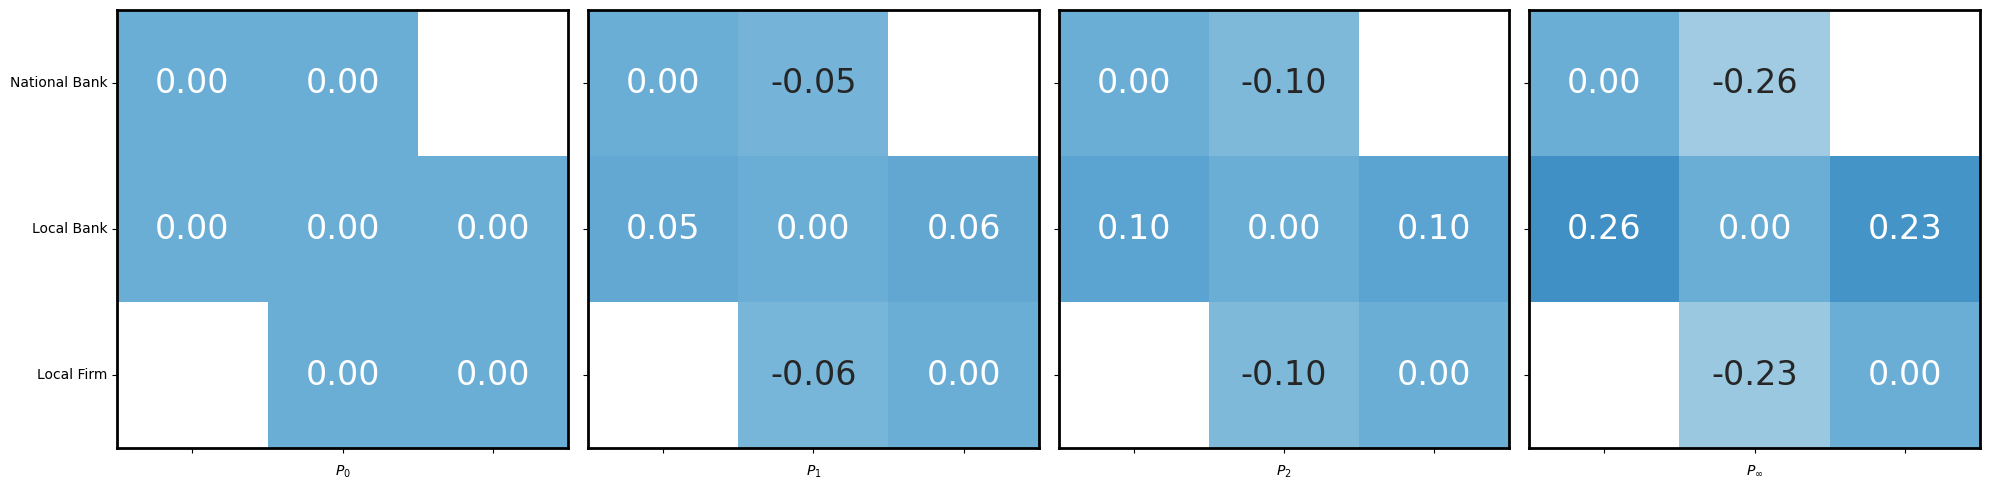

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

mask = [[False, False,  True],
       [False, False, False],
       [ True, False, False]]

global_min = -1.0
global_max = 1.0
# Iterate over the heatmaps and axes
index_set = [0, 1, 2, -1]
custom_annotations = [
    ("X", 0, 2),  # (text, row, column)
    ("X", 2, 0),
]

for i, ax in enumerate(axes):

    data_with_mask = np.where(mask, np.nan, P_list[index_set[i]])

    res = sns.heatmap(data_with_mask, annot=True, ax=ax, cmap='Blues', cbar=False,
                annot_kws={"size": 24}, vmin=global_min, vmax=global_max, fmt='.2f')
    for _, spine in res.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_color('k')

# Create arrows from 0 to 1 and 1 to 2
arrowprops = dict(facecolor='black', shrink=0.05)

# Remove y-axis labels for the second and third subplots
axes[1].set_yticklabels([])
axes[2].set_yticklabels([])
axes[3].set_yticklabels([])

axes[0].set_yticklabels([
    'National Bank', 'Local Bank', 'Local Firm'
], rotation=0
)

axes[1].set_xticklabels([])
axes[2].set_xticklabels([])
axes[0].set_xticklabels([])
axes[3].set_xticklabels([])

for i in range(3):
    axes[i].set_xlabel(fr'$P_{{{index_set[i]}}}$')
axes[3].set_xlabel(r'$P_\infty$')

# Adjust subplot spacing
plt.tight_layout()
# plt.savefig('../figs/prices_side_by_side.eps', format='eps', dpi=700)

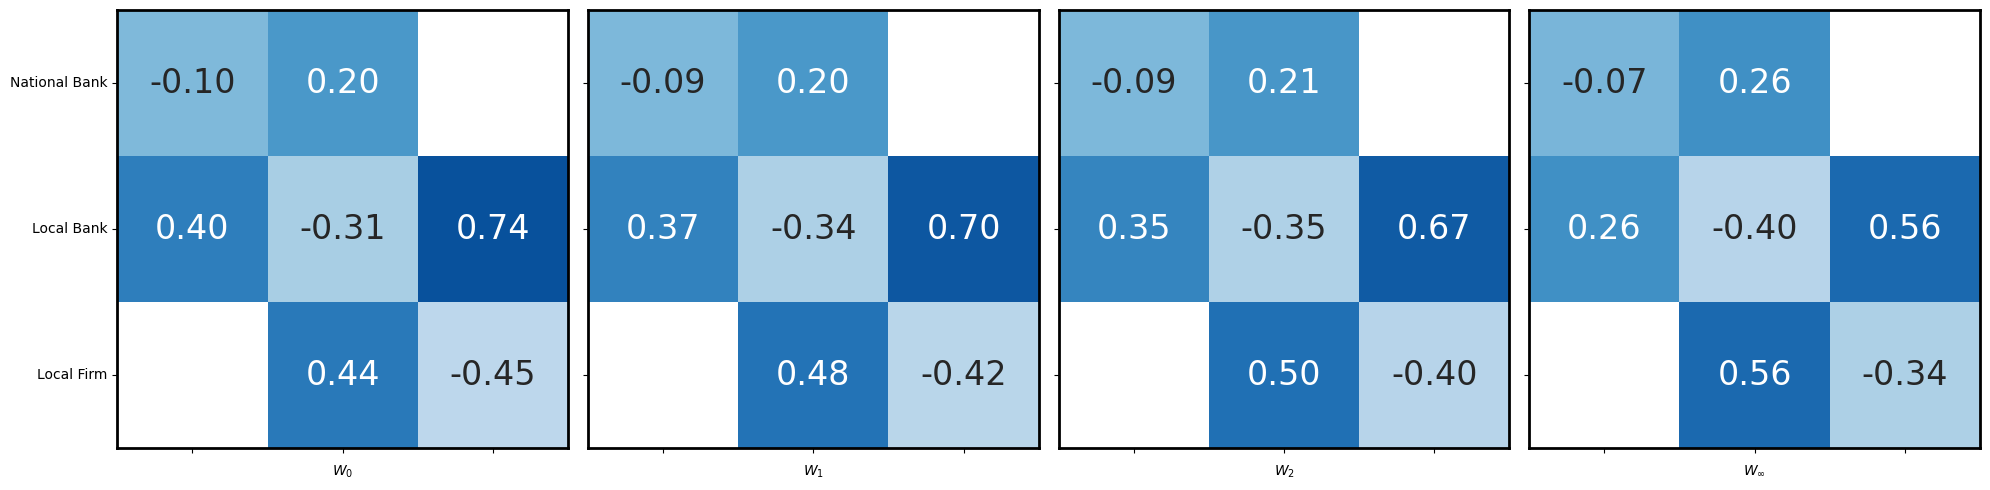

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

global_min = -1.0
global_max = 1.0
# Iterate over the heatmaps and axes
#index_set = [0, 1, 2, -1]
# custom_annotations = [
#     ("X", 0, 2),  # (text, row, column)
#     ("X", 2, 0),
# ]
mask = [[False, False,  True],
       [False, False, False],
       [ True, False, False]]

for i, ax in enumerate(axes):
    data_with_mask = np.where(mask, np.nan, W_list[index_set[i]])

    res = sns.heatmap(data_with_mask, annot=True, ax=ax, cmap='Blues', cbar=False,
                annot_kws={"size": 24}, vmin=global_min, vmax=global_max, fmt='.2f')
    for _, spine in res.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_color('k')

    # for annotation in custom_annotations:
    #     text, row, col = annotation
    #     ax.annotate(text, xy=(col + 0.5, row + 0.5), color='red',
    #                 fontsize=80, ha='center', va='center')


# Create arrows from 0 to 1 and 1 to 2
arrowprops = dict(facecolor='black', shrink=0.05)


# Remove y-axis labels for the second and third subplots
axes[1].set_yticklabels([])
axes[2].set_yticklabels([])
axes[3].set_yticklabels([])

axes[0].set_yticklabels([
    'National Bank', 'Local Bank', 'Local Firm'
], rotation=0
)

axes[1].set_xticklabels([])
axes[2].set_xticklabels([])
axes[0].set_xticklabels([])
axes[3].set_xticklabels([])

for i in range(3):
    axes[i].set_xlabel(fr'$W_{{{index_set[i]}}}$')
axes[3].set_xlabel(r'$W_\infty$')

# Adjust subplot spacing
plt.tight_layout()
# plt.savefig('../figs/w_side_by_side.eps', format='eps', dpi=700)

## Ejemplo 5 sin restricciones

In [13]:
W_list, P_list = run_price_dynamics(cov_mat,
                                    mean_mat,
                                    [], eta = 0.5, #poner '(0,2)' dentro de los corchetes para replicar el ejemplo 5 o dejarlo vacío para que no existan restricciones
                                    Gamma = gamma_mat,
                                    num_iterations=500
                                   )

Q matrices: [array([[ 1.33333333,  0.41666667, -1.25      ],
       [ 0.41666667,  0.91145833, -0.859375  ],
       [-1.25      , -0.859375  ,  1.953125  ]]), array([[ 1.33333333,  0.41666667, -1.25      ],
       [ 0.41666667,  0.91145833, -0.859375  ],
       [-1.25      , -0.859375  ,  1.953125  ]]), array([[ 1.33333333,  0.41666667, -1.25      ],
       [ 0.41666667,  0.91145833, -0.859375  ],
       [-1.25      , -0.859375  ,  1.953125  ]])]
0


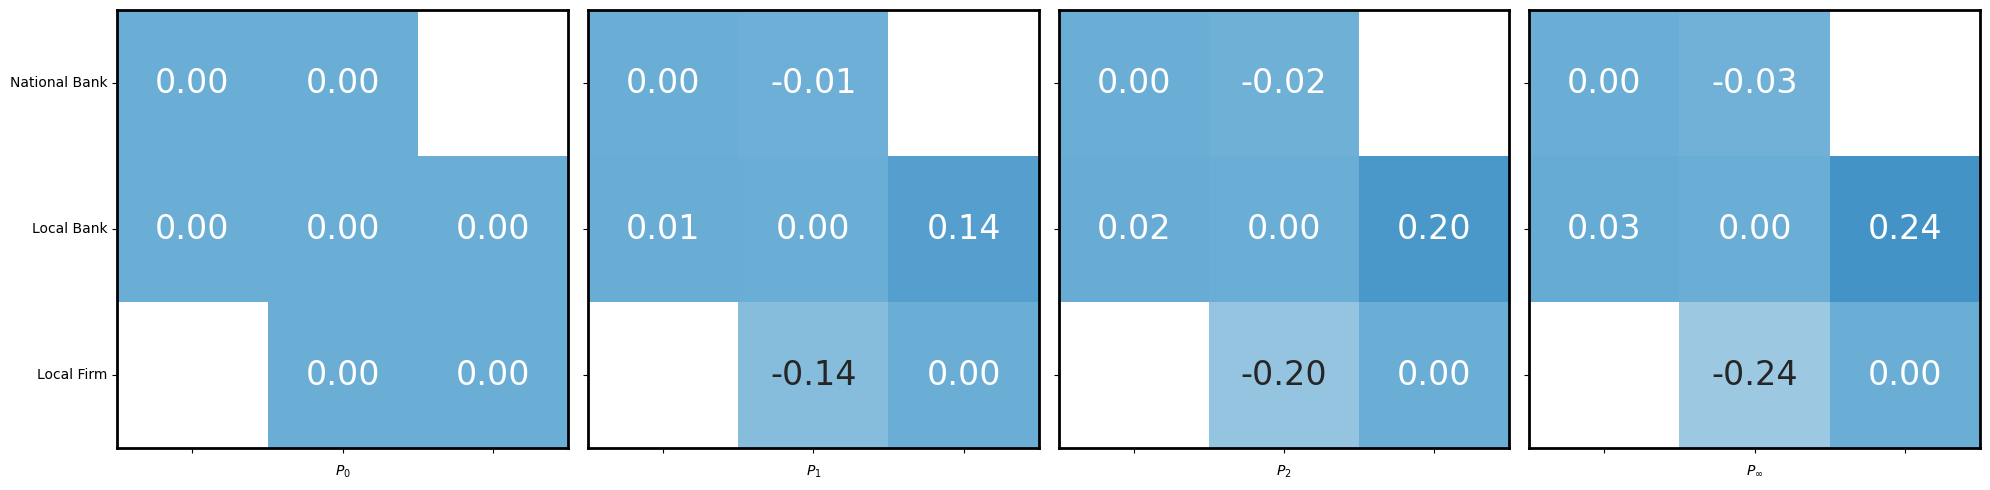

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

mask = [[False, False,  True],
       [False, False, False],
       [ True, False, False]]

global_min = -1.0
global_max = 1.0
# Iterate over the heatmaps and axes
index_set = [0, 1, 2, -1]
custom_annotations = [
    ("X", 0, 2),  # (text, row, column)
    ("X", 2, 0),
]

for i, ax in enumerate(axes):

    data_with_mask = np.where(mask, np.nan, P_list[index_set[i]])

    res = sns.heatmap(data_with_mask, annot=True, ax=ax, cmap='Blues', cbar=False,
                annot_kws={"size": 24}, vmin=global_min, vmax=global_max, fmt='.2f')
    for _, spine in res.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_color('k')

# Create arrows from 0 to 1 and 1 to 2
arrowprops = dict(facecolor='black', shrink=0.05)

# Remove y-axis labels for the second and third subplots
axes[1].set_yticklabels([])
axes[2].set_yticklabels([])
axes[3].set_yticklabels([])

axes[0].set_yticklabels([
    'National Bank', 'Local Bank', 'Local Firm'
], rotation=0
)

axes[1].set_xticklabels([])
axes[2].set_xticklabels([])
axes[0].set_xticklabels([])
axes[3].set_xticklabels([])

for i in range(3):
    axes[i].set_xlabel(fr'$P_{{{index_set[i]}}}$')
axes[3].set_xlabel(r'$P_\infty$')

# Adjust subplot spacing
plt.tight_layout()
# plt.savefig('../figs/prices_side_by_side.eps', format='eps', dpi=700)

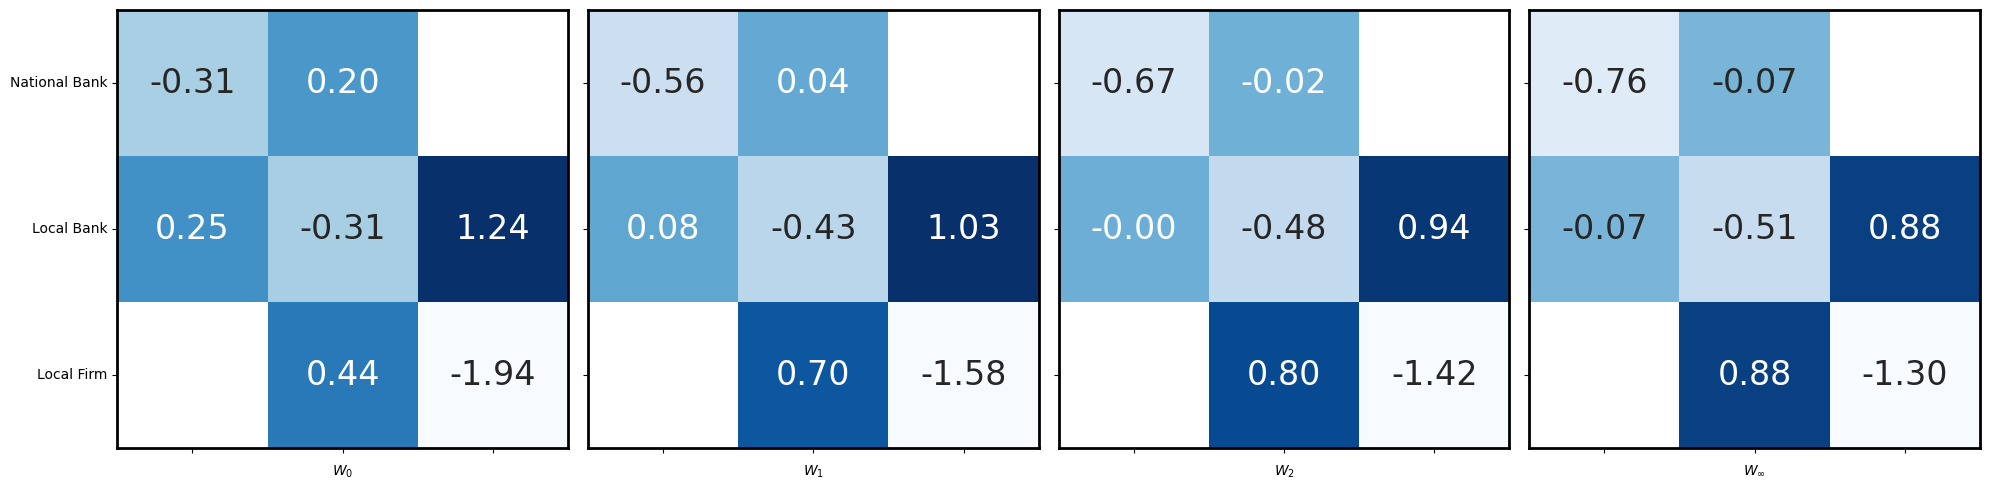

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

global_min = -1.0
global_max = 1.0
# Iterate over the heatmaps and axes
#index_set = [0, 1, 2, -1]
# custom_annotations = [
#     ("X", 0, 2),  # (text, row, column)
#     ("X", 2, 0),
# ]
mask = [[False, False,  True],
       [False, False, False],
       [ True, False, False]]

for i, ax in enumerate(axes):
    data_with_mask = np.where(mask, np.nan, W_list[index_set[i]])

    res = sns.heatmap(data_with_mask, annot=True, ax=ax, cmap='Blues', cbar=False,
                annot_kws={"size": 24}, vmin=global_min, vmax=global_max, fmt='.2f')
    for _, spine in res.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_color('k')

    # for annotation in custom_annotations:
    #     text, row, col = annotation
    #     ax.annotate(text, xy=(col + 0.5, row + 0.5), color='red',
    #                 fontsize=80, ha='center', va='center')


# Create arrows from 0 to 1 and 1 to 2
arrowprops = dict(facecolor='black', shrink=0.05)


# Remove y-axis labels for the second and third subplots
axes[1].set_yticklabels([])
axes[2].set_yticklabels([])
axes[3].set_yticklabels([])

axes[0].set_yticklabels([
    'National Bank', 'Local Bank', 'Local Firm'
], rotation=0
)

axes[1].set_xticklabels([])
axes[2].set_xticklabels([])
axes[0].set_xticklabels([])
axes[3].set_xticklabels([])

for i in range(3):
    axes[i].set_xlabel(fr'$W_{{{index_set[i]}}}$')
axes[3].set_xlabel(r'$W_\infty$')

# Adjust subplot spacing
plt.tight_layout()
# plt.savefig('../figs/w_side_by_side.eps', format='eps', dpi=700)

## Actualización 8/10/2024

Demostrar que existe un punto de equilibrio único y estable, para garantizar que los agentes alcanzan un equilibrio óptimo en la distribución de sus transacciones, y que sus decisiones convergerán a ese punto.

### Teorema 1 (Existencia y unicidad de un punto estable) 

Los agentes alcanzarán siempre el mismo punto de equilibrio si comienzan desde condiciones iniciales diferentes.

### Teorema 4 (Condiciones de convergencia)

Punto estable al cual se converge.

## Actualización  2/10/2024

### Objetivo

El objetivo general es desarrollar un modelo teórico que permita analizar cómo los agentes financieros optimizan la distribución de sus transacciones entre sistemas financieros tradicionales y blockchain, maximizando su utilidad total.


El modelo teórico derivará las condiciones bajo las cuales los agentes alcanzan un equilibrio estable entre la cantidad de transacciones que destinan a blockchain y a los sistemas tradicionales, o en qué condiciones uno de los sistemas prevalece sobre el otro.


### Problema de Maximización

El agente debe optimizar dos decisiones:

- **$\alpha$**: La proporción de la transacción destinada a blockchain.
- **$w_i$**: El tamaño total de la transacción.

Y tiene que resolver el siguiente problema de optimización:

$$
\max_{\alpha, w_i} U_i(W, \alpha, \tilde{P}, \hat{P}, N_{\text{blockchain}})
$$

### Función de Utilidad:

$$
U_i(W, \alpha, \tilde{P}, \hat{P}, N_{\text{blockchain}}) = (1 - \alpha) w_i^T (\tilde{\mu}_i - \tilde{P}e_i) - \gamma_i (1 - \alpha) w_i^T \tilde{\Sigma} (1 - \alpha) w_i
$$
$$
+ \alpha w_i^T (\hat{\mu}_i - \hat{P}e_i) - \gamma_i \alpha w_i^T \hat{\Sigma} \alpha w_i
$$
$$
- \gamma \cdot R_{\text{tradicional}}(w_i, H_{\text{blockchain}}) + \phi_i \cdot C_{\text{tradicional}}
- \gamma \cdot \frac{H_{\text{blockchain}}(w_i, R_{\text{tradicional}})}{N_{\text{blockchain}}} + \eta_i \cdot N_{\text{blockchain}}
$$

#### Distribución del contrato entre sistemas:

   - $(1 - \alpha) w_i$: Proporción del contrato total $w_i$ que el agente asigna al **sistema tradicional**.
   - $\alpha w_i$: Proporción del contrato total que el agente asigna a **blockchain**.
   - $\alpha$: Proporción de la transacción destinada a blockchain, con $\alpha \in [0, 1]$.

####  Beneficios esperados:
   - **Para el sistema tradicional**:
     - $\tilde{\mu}_i$: Beneficios esperados por el agente en el sistema tradicional.
     - $\tilde{P}$: Costos de transacción en el sistema tradicional (tarifas bancarias, costos de intermediación).
     - $e_i$: Vector que representa al agente.
   - **Para blockchain**:
     - $\hat{\mu}_i$: Beneficios esperados en blockchain.
     - $\hat{P}$: Costos de transacción en blockchain (comisiones de gas).

####  Riesgos financieros en cada sistema:

   - **Sistema tradicional**:
     - $- \gamma_i (1 - \alpha) w_i^T \tilde{\Sigma} (1 - \alpha) w_i$: Este término representa los **riesgos financieros** (volatilidad) en el sistema tradicional, con $\tilde{\Sigma}$ como la matriz de covarianza de riesgos.
   - **Blockchain**:
     - $- \gamma_i \alpha w_i^T \hat{\Sigma} \alpha w_i$: Riesgos financieros en blockchain, ponderados por $\alpha$, donde $\hat{\Sigma}$ es la matriz de covarianza de los riesgos financieros en blockchain.

####  Riesgos interdependientes entre sistemas:

   - $\gamma \cdot R_{\text{tradicional}}(w_i, H_{\text{blockchain}})$: Este término refleja el **riesgo regulatorio** en el sistema tradicional, que depende del tamaño de la transacción ($w_i$) y del riesgo de hackeo en blockchain ($H_{\text{blockchain}}$).
   - $\gamma \cdot \frac{H_{\text{blockchain}}(w_i, R_{\text{tradicional}})}{N_{\text{blockchain}}}$: Riesgo de hackeo en blockchain, que depende del tamaño de la red ($N_{\text{blockchain}}$) y el riesgo en el sistema tradicional.

####  Confianza institucional en el sistema tradicional:

   - $\phi_i \cdot C_{\text{tradicional}}$: Término que captura el nivel de **confianza institucional** en las instituciones financieras tradicionales, que afecta positivamente la utilidad derivada de operar en ese sistema.

####  Efectos de red en blockchain:

   - $\eta_i \cdot N_{\text{blockchain}}$: Término que mide el efecto de red en blockchain. A medida que el número de participantes en la red ($N_{\text{blockchain}}$) crece, la seguridad y la liquidez aumentan, lo que incrementa la utilidad para los agentes.

---


## Idea de Tesis 26/09/2024
Comparar la utilidad y los riesgos que enfrentan los participantes en sistemas financieros basados en blockchain frente a los sistemas financieros tradicionales. A través de funciones de utilidad para ambos sistemas, se analizarán los costos de transacción, riesgos de seguridad, confianza institucional y efectos de red. El objetivo es entender qué factores determinan la preferencia de los usuarios y si es posible lograr un equilibrio estable en cada sistema o si uno prevalecerá sobre el otro.


### Posible función de utilidad en un sistema blockchain

La función de utilidad para un participante $i$ en un sistema blockchain se definiría como:

$$
U_{\text{blockchain}, i} = w_i^T (\mu_i - C e_i) - \gamma_i \cdot w_i^T \Sigma_i w_i - \lambda_i \cdot H_i + \eta_i \cdot N_i
$$

Donde:

- $w_i$: Tamaño de las transacciones o contratos del participante $i$.
- $\mu_i$: Beneficios esperados de las transacciones.
- $C$: Costos de utilizar blockchain (fees).
- $\gamma_i$: Coeficiente de aversión al riesgo.
- $\Sigma_i$: Matriz de covarianza de riesgos.
- $\lambda_i$: Coeficiente de riesgo de hackeo.
- $H_i$: Riesgo de hackeo.
- $\eta_i$: Coeficiente de efecto de red.
- $N_i$: Tamaño de la red o liquidez.



### Posible función de utilidad en un sistema tradicional

$$
U_{\text{tradicional}, i} = w_i^T (\mu_i - F e_i) - \beta_i \cdot R_i + \phi_i \cdot C_i
$$

Donde:

- $w_i$: Tamaño de las transacciones del participante $i$.
- $\mu_i$: Beneficios esperados en el sistema tradicional.
- $F$: Costos de transacción (comisiones bancarias, tarifas de intermediarios).
- $e_i$: Vector que representa al participante $i$.
- $\beta_i$: Coeficiente de aversión al riesgo regulatorio.
- $R_i$: Riesgo regulatorio (cumplimiento normativo, costos legales).
- $\phi_i$: Sensibilidad a la confianza institucional (protección por parte de bancos o entidades financieras).
- $C_i$: Nivel de confianza en las instituciones tradicionales.

# 